# Running the test script test_front.py

This notebook runs test_front.py to demonstrate how it works and what it is doing. Basically it produces data from a weather front calculation (using /data/front_test.nc) and then compares it to the original code (or a text output from the original code located at /test/900hPa_fronts_2020-01-01T00.json).

In [2]:
# Import fronts.py. In Jupyter I need to add the path to this file even though it's in the same directory for some reason.
import sys
sys.path.append('/home/561/sg7549/frontdetection')
import fronts

# Import Libraries needed to work with the data.
import json
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
import xarray as xr
import numpy as np

# Libraries needed for testing whether the new answer is good or not.
from xarray.testing import assert_allclose
from numpy.testing import assert_allclose as np_assert

# Introducing potential replacement libraries from MetPy.
from metpy.calc import wet_bulb_temperature, dewpoint_from_specific_humidity
from metpy.units import units

# Libraries needed to plot the answers.
import matplotlib.pyplot as plt
import cartopy.crs as ccrs

### Data that is the same as the test sample

Create a function to call the original front calculation from fronts.py. We will use the answer from this and compare it to a sample answer to make sure it is still consistant.

In [3]:
def test_front_detection():
    # Open the test dataset stored in the repository. This has been saved from ERA5 data to make it faster to run each time.
    test_data = xr.open_dataset('frontdetection/tests/front_test.nc')

    # Save the required variables from the data.
    ta = test_data.t
    ua = test_data.u
    va = test_data.v
    hus = test_data.q
    
    # Use the wetbulb function from fronts.py to calculate the wetbulb temperature from pressure-level data.
    t_wet=fronts.wetbulb(ta,hus,900,steps=120)
    
    # Call the fronts function from fronts.py to identify fronts in data. 
    frontdata=fronts.front(t_wet,ua,va,threshold_i=-1e-10,numsmooth=9,minlength=50)
    
    timestring=np.datetime_as_string(test_data.time.data,unit='h')
    # Now we load in the sample answer.
    with open(f'frontdetection/tests/900hPa_fronts_{timestring}.json') as sample_file:
        sample = json.load(sample_file)

        # We use assert to directly compare the data calculated from frontdata to the sample data.
        # If the answers are exactly the same then nothing happens, but if they are different then specified error message will show.
        assert frontdata == sample, f"result isn't comparable with test data"

    # We also return the calculated data to plot later.
    return frontdata, t_wet

In [4]:
# Now we can call test_front_detection() to see if the answers matched:
fr = test_front_detection()

Ok no error was thrown out so we know our answers matched.

- We will plot the data now to see what it looks like

In [5]:
# Save the 2 variables from the test_front_detection() function.
lines = fr[0]
clines=lines['cold_fronts']
wlines=lines['warm_fronts']
slines=lines['stationary_fronts']

t_wet = fr[1]

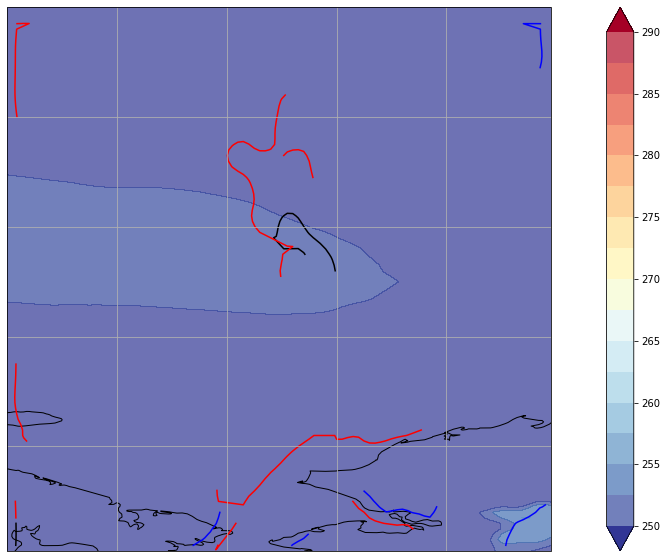

In [6]:
# Create the figure and plot the data:
fig=plt.figure(figsize=(20,10))
ax = fig.add_subplot(1, 1, 1, projection=ccrs.PlateCarree())
ax.coastlines()
ax.gridlines()
#ax.set_extent([110,180,-10,-60])
f=ax.contourf(t_wet.longitude,t_wet.latitude,t_wet,np.arange(250,291,2.5),extend='both',transform=ccrs.PlateCarree(),cmap='RdYlBu_r', alpha=0.7)
for n in range(len(slines)):
    ax.plot(slines[n][1],slines[n][0],'k',ms=1,transform=ccrs.PlateCarree())
for n in range(len(wlines)):
    ax.plot(wlines[n][1],wlines[n][0],'r',ms=1,transform=ccrs.PlateCarree())
for n in range(len(clines)):
    ax.plot(clines[n][1],clines[n][0],'b',ms=1,transform=ccrs.PlateCarree())
cbar=fig.colorbar(f)

This above figure shows the warm fronts in red, the cold fronts in blue, and the statinoary fronts in black. The contour backdrop shows the wetbulb temperature.

- Here is what the data looks like:

In [13]:
lines

{'cold_fronts': [[[65.5,
    65.51701545827734,
    65.66759401822918,
    65.75,
    65.84223699315612,
    66.0,
    66.11325239985489,
    66.25,
    66.46454103861915,
    66.5,
    66.75,
    67.0],
   [-171.53074841157726,
    -171.5,
    -171.25,
    -171.11244395026617,
    -171.0,
    -170.8592005670991,
    -170.75,
    -170.66181463330673,
    -170.5,
    -170.4784184939164,
    -170.386735671033,
    -170.31752689678675],
   [2.172566974950292e-05,
    2.1422556485962917e-05,
    1.995141678547839e-05,
    1.9534503261088706e-05,
    1.8195683753056156e-05,
    1.6411288072212788e-05,
    1.4300373501758966e-05,
    1.2226519690728524e-05,
    1.0765993149148156e-05,
    1.063564759269068e-05,
    1.2436994585954892e-05,
    1.3364264168479947e-05]],
  [[65.5,
    65.53157854996782,
    65.68114253252014,
    65.75,
    65.81450530847725,
    66.0],
   [-167.03736203544074,
    -167.0,
    -166.75,
    -166.61253556466093,
    -166.5,
    -166.2984566945652],
   [7.81791504

### Data that is NOT the same as the test sample

Here we create a function that is similar to test_front_detection from above but using the Metpy module instead of fronts.py.

In [21]:
def test_front_detection_metpy():

    test_data = xr.open_dataset('frontdetection/tests/front_test.nc')

    ta = test_data.t
    ua = test_data.u
    va = test_data.v
    hus = test_data.q
    lvl = test_data.level
    
    dewpoint = dewpoint_from_specific_humidity(pressure=lvl,
                                               temperature=ta,
                                               specific_humidity=hus)

    t_wet = wet_bulb_temperature(pressure=900*units.hPa,
                                 temperature=ta,
                                 dewpoint=dewpoint)
    
    frontdata = fronts.front(t_wet,
                             ua,
                             va,
                             threshold_i=-1e-10,
                             numsmooth=9,
                             minlength=50)
    
    timestring=np.datetime_as_string(test_data.time.data,unit='h')

    with open(f'frontdetection/tests/900hPa_fronts_{timestring}.json') as sample_file:
        sample = json.load(sample_file)

        #assert frontdata == sample, f"result isn't comparable with test data"

    return frontdata, t_wet

In [20]:
# Now we can call test_front_detection_metpy() to see if the answers matched:
test_front_detection_metpy()

AssertionError: result isn't comparable with test data

This time an error was thrown out so we know our answers didn't match. That means there is something different between the method in fronts.py and the metpy method, even though they are supposed to be calculating the same thing.

- We will plot the data now to see what it looks like

In [22]:
# Save the 2 variables from the test_front_detection() function.
fr_met = test_front_detection_metpy()
lines_met = fr_met[0]
clines_met=lines_met['cold_fronts']
wlines_met=lines_met['warm_fronts']
slines_met=lines_met['stationary_fronts']

t_wet_met = fr_met[1]

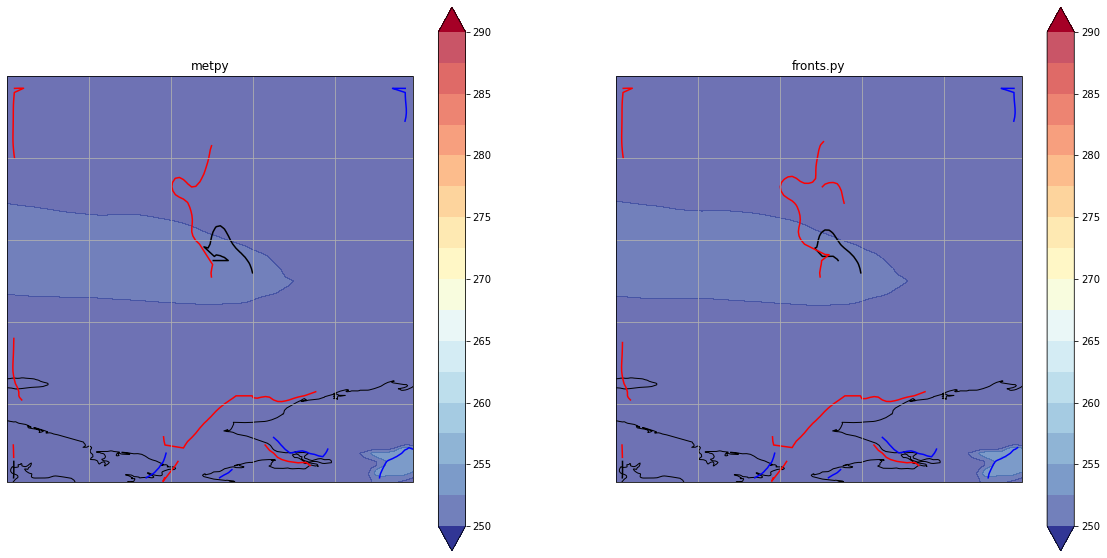

In [39]:
# Create the figure and plot the data:
fig=plt.figure(figsize=(20,10))
ax = fig.add_subplot(1, 2, 1, projection=ccrs.PlateCarree())
ax.coastlines()
ax.gridlines()
plt.title('metpy')
#ax.set_extent([110,180,-10,-60])
f=ax.contourf(t_wet_met.longitude,t_wet_met.latitude,t_wet_met,np.arange(250,291,2.5),extend='both',transform=ccrs.PlateCarree(),cmap='RdYlBu_r', alpha=0.7)
for n in range(len(slines_met)):
    ax.plot(slines_met[n][1],slines_met[n][0],'k',ms=1,transform=ccrs.PlateCarree())
for n in range(len(wlines_met)):
    ax.plot(wlines_met[n][1],wlines_met[n][0],'r',ms=1,transform=ccrs.PlateCarree())
for n in range(len(clines_met)):
    ax.plot(clines_met[n][1],clines_met[n][0],'b',ms=1,transform=ccrs.PlateCarree())
cbar=fig.colorbar(f)

ax1 = fig.add_subplot(1, 2, 2, projection=ccrs.PlateCarree())
ax1.coastlines()
ax1.gridlines()
plt.title('fronts.py')
#ax.set_extent([110,180,-10,-60])
f=ax1.contourf(t_wet.longitude,t_wet.latitude,t_wet,np.arange(250,291,2.5),extend='both',transform=ccrs.PlateCarree(),cmap='RdYlBu_r', alpha=0.7)
for n in range(len(slines)):
    ax1.plot(slines[n][1],slines[n][0],'k',ms=1,transform=ccrs.PlateCarree())
for n in range(len(wlines)):
    ax1.plot(wlines[n][1],wlines[n][0],'r',ms=1,transform=ccrs.PlateCarree())
for n in range(len(clines)):
    ax1.plot(clines[n][1],clines[n][0],'b',ms=1,transform=ccrs.PlateCarree())
cbar=fig.colorbar(f)

These two sets of data are pretty similar, only a couple of differences can be seen.